In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [4]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [5]:
data.shape

(4340, 8)

In [6]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [8]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [ ]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

In [ ]:
X.isna().sum()

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric
    
    
    def fit(self, X, y):
        X_fit = X.copy()
        y_fit = y.copy()

        # concatenate X and y for future calcs
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        
        # calculating mean values of target for Mean Target Encoding
        self.dict_means = {col : X_with_target.groupby(col)[y_fit.name].mean()
                          for col in self.categorical}

        return self
        
    def transform(self, df):
        
        X_ = df.copy()
           
        # Mean Target Encoding
        C = .006
        for col in self.categorical:
            X_[col] = X_[col].map(self.dict_means[col]) + (C * np.random.normal())
            mean_value = self.dict_means[col].values.mean() + (C * np.random.normal())
            X_[col] = X_[col].fillna(mean_value)
            
        # Dealing wiht missing and extra columns
        missing_columns = [x 
                           for x in all_ohe
                           if x not in X_.columns
                           and
                           x not in self.numeric]

        extra_columns = [x
                         for x in data_part_cols
                         if x not in all_ohe]
        
        ### Clean up new categories
        X_ = X_.drop(extra_columns, axis=1)
    
        
        ### Columns with missing data, fill it with np.zeros
        
        if len(missing_columns) != 0:

            zeros = np.zeros((X_.shape[0], len(missing_columns)))
            zeros = pd.DataFrame(zeros,
                                 columns=missing_columns,
                                 index=X_.index)

            X_ = pd.concat((X_, zeros), axis=1)
        
        
        return X_[sorted(X_.columns)]

In [54]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(object_cols,num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

test.head()

,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,km_driven,name,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,year
2761,0,1,0.0,0,0,15000,13.672203,1,0,0,0,0,0,1,0,0,1,13.563333
3210,0,1,0.0,0,0,70000,13.045355,0,0,1,0,0,0,1,0,0,1,12.939344
2606,0,1,0.0,0,0,90000,13.127754,1,0,0,0,0,0,1,0,0,1,12.637431
1030,0,0,0.0,0,1,41000,12.389795,1,0,0,0,0,1,0,0,0,1,13.146012
3942,0,1,0.0,0,0,71318,13.383220,1,0,0,0,0,1,0,0,0,1,12.939344


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [55]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [76]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

res_dict = {}

for i in max_depth_list:
    pipe = Pipeline([
        ('cust_transformer', MeanTargetEncoderNoise(categorical=object_cols,
                                                    numeric=num_cols)),
        ('dec_tree', DecisionTreeRegressor(max_depth=i))
    ])

    pipe.fit(X_train, y_train)
    
    res_dict[i] = mse(pipe.predict(X_test), y_test)
    
    

In [77]:
print(res_dict)

{3: 0.23852576973514025, 5: 0.2237842935462303, 8: 0.21052297114923227, 12: 0.1960129999380575}


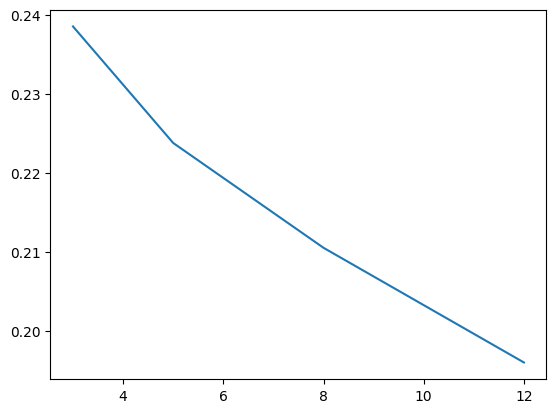

In [78]:
plt.plot(res_dict.keys(), res_dict.values())
plt.show()

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "dec_tree__max_depth": [3, 5, 8, 12],
    "dec_tree__min_samples_split": [10, 50, 100, 500],
    "dec_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "dec_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

search = GridSearchCV(pipe, param_grid=param_grid)

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cust_transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('dec_tree',
                                        DecisionTreeRegressor(max_depth=12))]),
             param_grid={'dec_tree__max_depth': [3, 5, 8, 12],
                         'dec_tree__max_leaf_nodes': [100, 200, 500],
                         'dec_tree__min_impurity_decrease': [0, 0.1, 0.15, 0.2],
                         'dec_tree__min_samples_split': [10, 50, 100, 500]})

In [80]:
mse(y_test, search.predict(X_test))

0.21010432054148886